# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Simulate the data using``numpy.random`` package](#par2)<br>
[2.1 Simulate single variable](#par2.1)<br>
[2.1.1 Perfect process](#par2.1.1)<br>
[2.1.1 Simulate 'special causes'](#par2.1.2)<br>
[2.2 Simulate scrap ratio based on 10 dimensions](#par2.2)<br>
[3. Analise the data](#par3)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng()

<a id="par1"></a>
## 1. Problem statement

- Single manufacturing process step 
- Each part has 10 measured dimenions
    - Some dimensions are correlated
- If any of the 10 dimensions is measured outside of the specified limit, part is scrapped
- Parts are manufactured in batches of 10
- Tools are changes after batch is completed

<a id="par2"></a>
## 2. Simulate the data using ```numpy.random``` package

<a id="par2.1"></a>
### 2.1 Simulate single variable

<a id="par2.1.1"></a>
#### 2.1.1 Perfect process

Distribution of a measurements of a single dimension in the stable manufacturing process (process that has no special causes) follows normal distribution.

##### Define Dim1 attributes

Process capability:

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given process capability, we can calculate the underlying process standard deviation


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

In [3]:
# Nominal dimension
mu = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 3
# Number of observations
n=1000

In [4]:
dim1 = pd.Series(np.random.normal(mu, (usl-lsl)/(6*cp) , n))

##### Show distribution of dim1 using Histogram

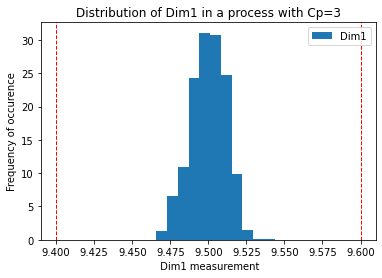

In [5]:
# Calculate number of Histogram bins using Sturge’s Rule
# as per: https://www.statisticshowto.com/choose-bin-sizes-statistics/
bins = int(np.round(np.log10(n)*3.322+1))

plt.hist(dim1, bins, density=True, label='Dim1')

# Draw a lines for upper and lower tolerances
plt.axvline(usl, color='r', linestyle='dashed', linewidth=1)
plt.axvline(lsl, color='r', linestyle='dashed', linewidth=1)

# define plot's parameters
plt.rcParams["figure.figsize"] = [8, 4]
plt.xlabel(' Dim1 measurement')
plt.ylabel('Frequency of occurence')
plt.title('Distribution of Dim1 in a process with Cp={}'.format(cp))
plt.legend()
plt.show()

In [35]:
# Define a function that will check if datapoints are violating any of the SPC rules
def spc_stats(data):
    
    # Add 'Reason' column to data table
    data['Reason'] = 0

    # calculate the mean of the variable
    x_bar = np.mean(data['Dim'])
    mr_bar = np.mean( np.abs(data['mR'][1:len(data['mR'])]))

    # Below calculations as per 'Implementing Six Sigma' Forrest W. Breyfogle III, p227
    # Calculate Upper and Lower Control Limits for X chart 
    ucl = x_bar+mr_bar*2.66
    lcl = x_bar-mr_bar*2.66

    # Calculate Upper Control Limits for mR chart (there is no lower CL for mR chart)
    mr_ucl = mr_bar+mr_bar*3.267    
    
    # Shewhart SPC control chart rules:
    # https://analyse-it.com/docs/user-guide/process-control/shewhart-control-chart-rules
    
    # Number of observation on the same side of the mean when the alarm is switched on (typically 8 or 9)
    n_side=8
    
    # Number of consecutive points steadily increasing or decreasing to switch the alarm (typically 6)
    n_drift = 4
    
    # Check for measurements aoutside the contro limits
    for index, row in data.iterrows():
        x = row[0]
        mr = row[1]
        
        if x>ucl or x<lcl:
            data.loc[index, 'Reason'] = 1
            
        if mr>mr_ucl:
            data.loc[index, 'Reason'] = 2
            
    
    # check if there ar at least 'n_side' points on the same side of the mean line
    
    # 1 if point is above x_bar, -1 if it's below
    data['xbar_side'] = np.sign(data['Dim'] - x_bar)

    # count running sum of last n_side ['xbar_side'] values
    data['sameside'] = data['xbar_side']
    for i in range(1, n_side):
        data['sameside'] =  data['sameside']  + data['xbar_side'].shift(i)
    
    data.loc[ np.abs(data['sameside'])==n_side , 'Reason'] = 3
    
    #ooc = ooc.append( data[data['Reason']==3][['Observation', 'Measurement',  'Reason']])
    
    return data[['Dim', 'mR', 'Reason']], x_bar, mr_bar, ucl, lcl, mr_ucl

In [36]:
def xmr(dim):
    # Below code for SPC chart originally taken from: https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051

    # Define list variable for moving ranges
    # Calculated as per https://stackoverflow.com/questions/30673209/pandas-compare-next-row
    MR = dim-dim.shift(1)

    # Concatenate mR Series with and rename columns
    data = pd.concat([dim, MR], axis=1).rename(columns={0:"Dim", 1:"mR"})
    
    # Find the points that are violating SPC rules
    data, x_bar, mr_bar, ucl, lcl, mr_ucl = spc_stats(data)

    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(15,15), sharex=True)

    # X chart
    # Graph all the points 
    axs[0].plot(data['Dim'], linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL or under LCL
    axs[0].plot(data[data['Reason']==1]['Dim'], linestyle="", marker='o', color='red')
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==3]['Dim'], linestyle="", marker='o', color='orange')

    # Plot blue horizontal line at the process mean
    axs[0].axhline(x_bar, color='blue')

    # Plot red dotted lines at UCL and LCL
    axs[0].axhline(ucl, color = 'red', linestyle = 'dashed')
    axs[0].axhline(lcl, color = 'red', linestyle = 'dashed')

    # Set Chart title and axis labels
    axs[0].set_title('Individual Chart')
    axs[0].set(xlabel='Part', ylabel='Measurement')


    # mR chart
    # Graph all the points 
    axs[1].plot( np.abs(data['mR']), linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL
    axs[1].plot(data[data['Reason']==2]['mR'], linestyle="", marker='o', color='red')

    # Plot blue horizontal line at the mR mean
    axs[1].axhline(mr_bar, color='blue')

    # Plot red dotted line at UCL
    axs[1].axhline(mr_ucl, color='red', linestyle ='dashed')

    axs[1].set_ylim(bottom=0)
    axs[1].set_title('mR Chart')
    axs[1].set(xlabel='Part', ylabel='Range')
    
    return data[data['Reason']>0]

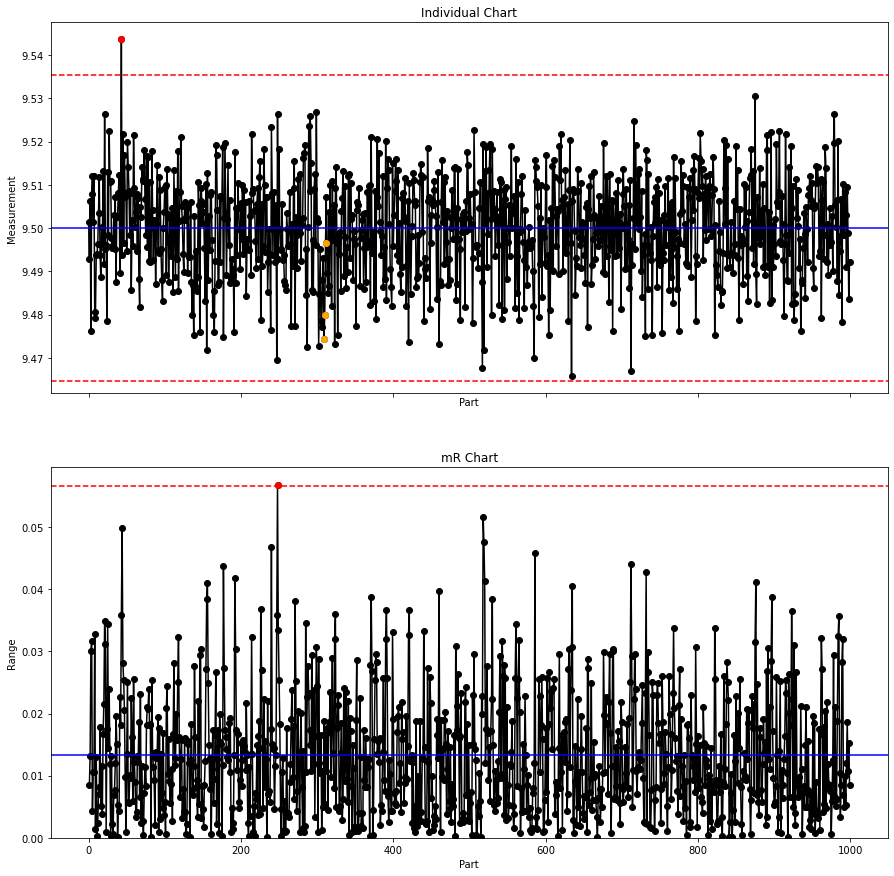

In [37]:
o = xmr(dim1)

,Dim,mR,Reason
43,9.543631,0.035780,1
248,9.526269,0.056803,2
309,9.474374,-0.018716,3
310,9.479886,0.005512,3
311,9.496578,0.016692,3


<a id="par2.1.2"></a>
#### 2.1.2 Simulate 'special causes'

<a id="par2.2"></a>
### 2.2 Simulate scrap ratio based on 10 dimensions

<a id="par3"></a>
## 3. Analyse the data

# End